# Boosting: The Art of Learning from Mistakes

**Core Concept:** Boosting reduces bias by sequentially training weak learners that focus on fixing previous mistakes.

**Analogy:** Like a student who reviews wrong answers, each new model focuses on what the previous models got wrong.

---

## Two Giants of Boosting:

### 1. AdaBoost (Adaptive Boosting)
- **Strategy:** Increase weights on misclassified samples
- **Tool:** Decision Stumps (depth=1)
- **Voting:** Weighted by model accuracy

### 2. Gradient Boosting (GBM)
- **Strategy:** Fit new models to residual errors
- **Tool:** Regression trees
- **Combination:** Additive with learning rate


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyBboxPatch
from ipywidgets import interact, IntSlider, Dropdown
import ipywidgets as widgets
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import io
from contextlib import redirect_stdout

# Import custom library
import sys
import os
sys.path.append(os.getcwd())

try:
    from MyML import MyAdaBoostClassifier, MyGradientBoostingRegressor, MyGradientBoostingClassifier
    from MyML import MyDecisionTreeClassifier, MyDecisionTreeRegressor
    print("SUCCESS: Boosting Modules Loaded!")
except ImportError as e:
    print(f"ERROR: {e}")

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100

SUCCESS: Boosting Modules Loaded!


## Part 1: Prepare Data

We use circles dataset - challenging for linear models but perfect for demonstrating boosting.

Classification data: 210 train, 90 test
Regression data: 100 samples


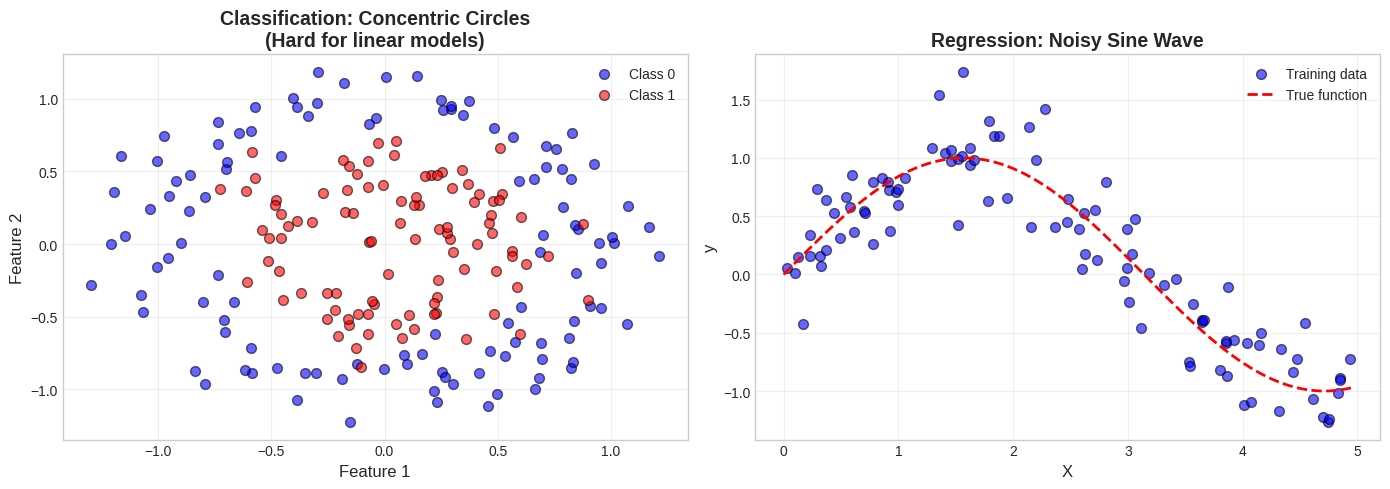

In [2]:
# Classification: Circles dataset
X_ada, y_ada = make_circles(n_samples=300, noise=0.15, factor=0.5, random_state=42)
X_train_ada, X_test_ada, y_train_ada, y_test_ada = train_test_split(
    X_ada, y_ada, test_size=0.3, random_state=42
)

# Regression: Sine wave with noise
np.random.seed(42)
X_gb = np.sort(5 * np.random.rand(100, 1), axis=0)
y_gb = np.sin(X_gb).ravel() + 0.3 * np.random.randn(100)
X_plot_gb = np.arange(0.0, 5.0, 0.05)[:, np.newaxis]

print(f"Classification data: {len(X_train_ada)} train, {len(X_test_ada)} test")
print(f"Regression data: {len(X_gb)} samples")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Classification
axes[0].scatter(X_train_ada[y_train_ada==0, 0], X_train_ada[y_train_ada==0, 1],
               c='blue', label='Class 0', alpha=0.6, s=50, edgecolors='k')
axes[0].scatter(X_train_ada[y_train_ada==1, 0], X_train_ada[y_train_ada==1, 1],
               c='red', label='Class 1', alpha=0.6, s=50, edgecolors='k')
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].set_title('Classification: Concentric Circles\n(Hard for linear models)', 
                 fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Regression
axes[1].scatter(X_gb, y_gb, c='blue', alpha=0.6, s=50, edgecolors='k', label='Training data')
axes[1].plot(X_plot_gb, np.sin(X_plot_gb), 'r--', linewidth=2, label='True function')
axes[1].set_xlabel('X', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
axes[1].set_title('Regression: Noisy Sine Wave', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 2: The Weak Learner Problem

A single stump (depth=1) is too simple - it's a "weak learner". Let's see how weak.

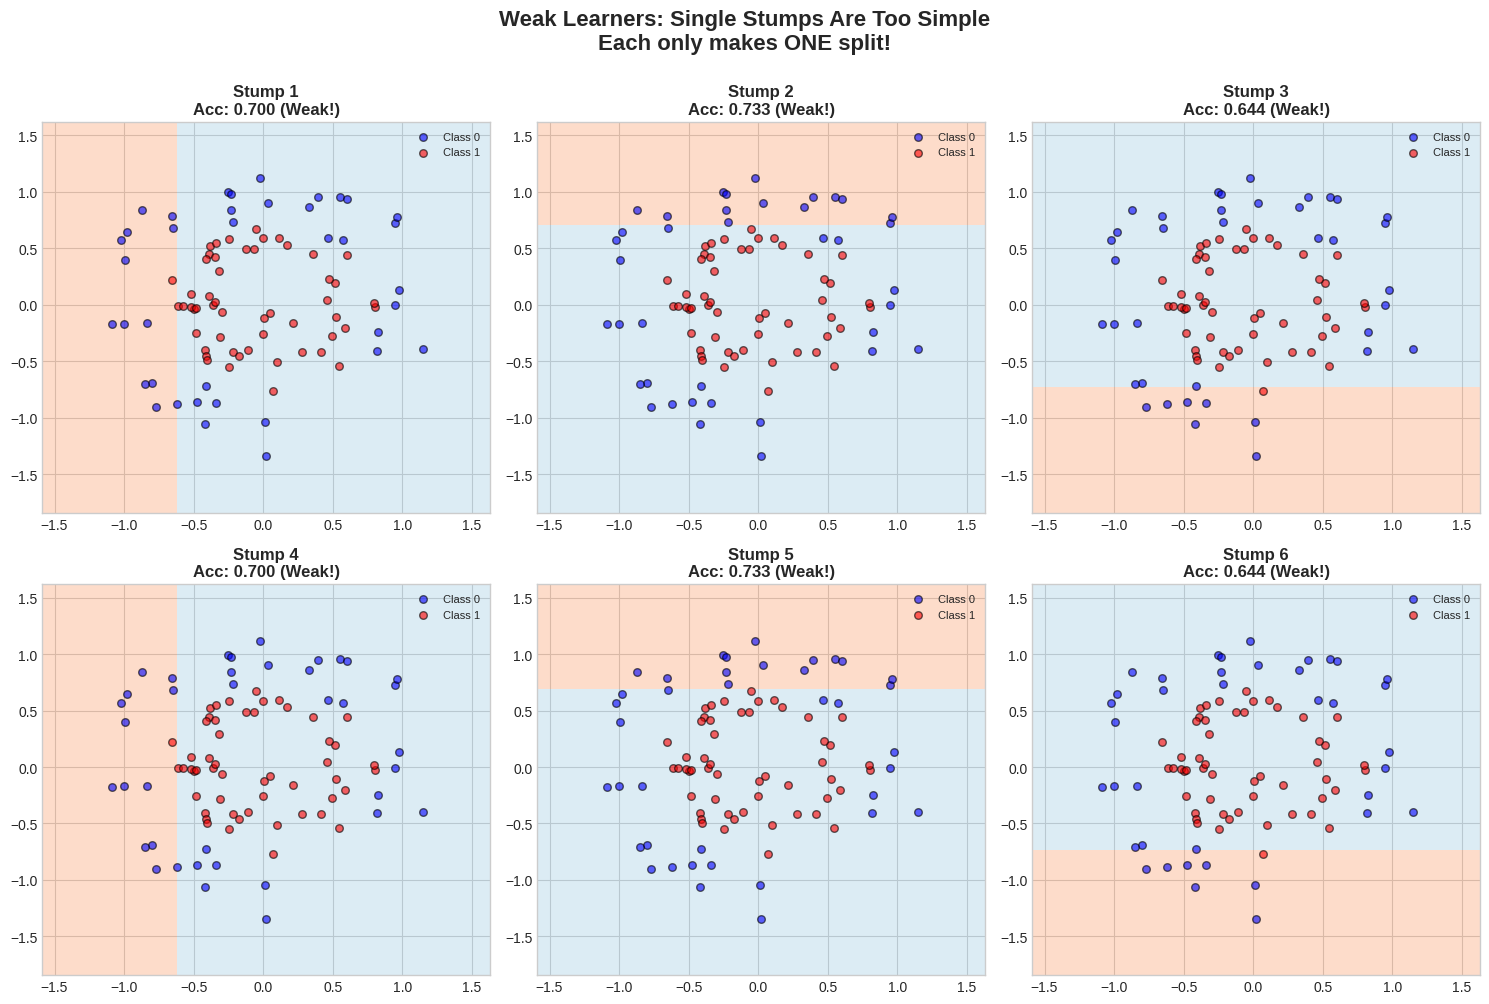


WEAK LEARNER ANALYSIS:
Average accuracy: 0.6926
Just slightly better than random (0.50)

KEY INSIGHT: These are HIGH BIAS models - they underfit!
Boosting will combine them to reduce bias.


In [3]:
def plot_decision_boundary(model, X, y, title, ax):
    """Plot decision boundary."""
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu', levels=1)
    ax.scatter(X[y==0, 0], X[y==0, 1], c='blue', 
               label='Class 0', alpha=0.6, s=30, edgecolors='k')
    ax.scatter(X[y==1, 0], X[y==1, 1], c='red', 
               label='Class 1', alpha=0.6, s=30, edgecolors='k')
    ax.set_title(title, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

# Train weak learners
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

np.random.seed(42)
weak_accs = []

for i in range(6):
    # Create bootstrap sample for variety
    indices = np.random.choice(len(X_train_ada), size=len(X_train_ada), replace=True)
    X_boot = X_train_ada[indices]
    y_boot = y_train_ada[indices]
    
    # Train stump (depth=1)
    stump = MyDecisionTreeClassifier(max_depth=1)
    stump.fit(X_boot, y_boot)
    
    acc = accuracy_score(y_test_ada, stump.predict(X_test_ada))
    weak_accs.append(acc)
    
    plot_decision_boundary(stump, X_test_ada, y_test_ada,
                          f"Stump {i+1}\nAcc: {acc:.3f} (Weak!)",
                          axes[i])

plt.suptitle('Weak Learners: Single Stumps Are Too Simple\nEach only makes ONE split!', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nWEAK LEARNER ANALYSIS:")
print("="*60)
print(f"Average accuracy: {np.mean(weak_accs):.4f}")
print(f"Just slightly better than random (0.50)")
print("\nKEY INSIGHT: These are HIGH BIAS models - they underfit!")
print("Boosting will combine them to reduce bias.")

## Part 3: AdaBoost - Interactive Evolution

Watch how AdaBoost progressively improves by focusing on mistakes.

In [4]:
def visualize_adaboost_evolution(n_estimators):
    """Visualize AdaBoost learning process."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Train AdaBoost
    ada = MyAdaBoostClassifier(n_estimators=n_estimators)
    ada.fit(X_train_ada, y_train_ada)
    
    # Single stump for comparison
    stump = MyDecisionTreeClassifier(max_depth=1)
    stump.fit(X_train_ada, y_train_ada)
    acc_stump = accuracy_score(y_test_ada, stump.predict(X_test_ada))
    
    # Plot 1: Single stump
    plot_decision_boundary(stump, X_test_ada, y_test_ada,
                          f"Single Stump\nAcc: {acc_stump:.4f}",
                          axes[0, 0])
    
    # Plot 2: AdaBoost ensemble
    acc_ada = accuracy_score(y_test_ada, ada.predict(X_test_ada))
    plot_decision_boundary(ada, X_test_ada, y_test_ada,
                          f"AdaBoost ({n_estimators} stumps)\nAcc: {acc_ada:.4f}",
                          axes[0, 1])
    
    # Plot 3: Sample weights evolution (show first/last)
    if n_estimators >= 2 and hasattr(ada, 'estimators_'):
        # Get predictions from first stump
        first_stump = ada.estimators_[0]
        y_pred_first = first_stump.predict(X_train_ada)
        errors_first = (y_pred_first != y_train_ada)
        
        # Visualize which samples are hard
        axes[1, 0].scatter(X_train_ada[~errors_first, 0], X_train_ada[~errors_first, 1],
                          c='green', alpha=0.3, s=50, label='Correct (low weight)')
        axes[1, 0].scatter(X_train_ada[errors_first, 0], X_train_ada[errors_first, 1],
                          c='red', alpha=0.8, s=150, marker='X', 
                          edgecolors='black', linewidths=2,
                          label='Errors (high weight)')
        axes[1, 0].set_title('After 1st Stump: Error Samples Upweighted', fontweight='bold')
        axes[1, 0].set_xlabel('Feature 1')
        axes[1, 0].set_ylabel('Feature 2')
        axes[1, 0].legend()
    
    # Plot 4: Accuracy progression
    n_range = range(1, n_estimators + 1, max(1, n_estimators // 20))
    train_accs = []
    test_accs = []
    
    for n in n_range:
        ada_temp = MyAdaBoostClassifier(n_estimators=n)
        ada_temp.fit(X_train_ada, y_train_ada)
        train_accs.append(accuracy_score(y_train_ada, ada_temp.predict(X_train_ada)))
        test_accs.append(accuracy_score(y_test_ada, ada_temp.predict(X_test_ada)))
    
    axes[1, 1].plot(n_range, train_accs, 'o-', label='Training', 
                   linewidth=2, markersize=6, color='blue')
    axes[1, 1].plot(n_range, test_accs, 's-', label='Test', 
                   linewidth=2, markersize=6, color='green')
    axes[1, 1].axhline(y=acc_stump, color='red', linestyle='--', 
                      linewidth=2, label='Single Stump')
    axes[1, 1].axvline(x=n_estimators, color='gray', linestyle=':', alpha=0.5)
    axes[1, 1].set_xlabel('Number of Stumps', fontweight='bold', fontsize=12)
    axes[1, 1].set_ylabel('Accuracy', fontweight='bold', fontsize=12)
    axes[1, 1].set_title('Learning Curve: Boosting Improves Over Time', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print stats
    improvement = (acc_ada - acc_stump) * 100
    print(f"\nCurrent: {n_estimators} stumps")
    print(f"Single stump: {acc_stump:.4f}")
    print(f"AdaBoost: {acc_ada:.4f}")
    print(f"Improvement: {improvement:+.2f}%")
    
    if len(test_accs) > 1:
        gap = train_accs[-1] - test_accs[-1]
        if gap > 0.1:
            print("\nWARNING: Large train-test gap! Possible overfitting.")
            print("Consider using fewer estimators or regularization.")

# Interactive widget
print("DRAG SLIDER to see how AdaBoost improves:\n")
interact(visualize_adaboost_evolution,
         n_estimators=IntSlider(min=1, max=100, step=5, value=10,
                               description='N Stumps:', continuous_update=False));

DRAG SLIDER to see how AdaBoost improves:



interactive(children=(IntSlider(value=10, continuous_update=False, description='N Stumps:', min=1, step=5), Ou…

## Part 4: Sample Weight Evolution

See how AdaBoost focuses more on difficult samples over iterations.

In [5]:
def visualize_weight_evolution(iteration):
    """Visualize how sample weights change during AdaBoost training."""
    
    # Train AdaBoost and track weights
    max_iter = min(iteration, 50)
    ada = MyAdaBoostClassifier(n_estimators=max_iter)
    
    # Manually simulate to get intermediate weights
    n_samples = len(X_train_ada)
    weights = np.ones(n_samples) / n_samples
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Train and track
    for i in range(max_iter):
        # Create weighted bootstrap (simplified simulation)
        stump = MyDecisionTreeClassifier(max_depth=1)
        stump.fit(X_train_ada, y_train_ada)
        
        # Get predictions and errors
        y_pred = stump.predict(X_train_ada)
        incorrect = (y_pred != y_train_ada)
        
        # Update weights (simplified AdaBoost rule)
        error_rate = np.sum(weights * incorrect) / np.sum(weights)
        if error_rate > 0 and error_rate < 1:
            alpha = 0.5 * np.log((1 - error_rate) / error_rate)
            weights = weights * np.exp(alpha * incorrect)
            weights = weights / np.sum(weights)
    
    # Plot 1: Current weights as bubble sizes
    # Normalize weights for visualization
    sizes = 1000 * weights / weights.max()
    
    scatter = axes[0].scatter(X_train_ada[:, 0], X_train_ada[:, 1],
                             c=y_train_ada, cmap='RdYlBu',
                             s=sizes, alpha=0.6, edgecolors='k')
    axes[0].set_xlabel('Feature 1', fontsize=12)
    axes[0].set_ylabel('Feature 2', fontsize=12)
    axes[0].set_title(f'Sample Weights After {max_iter} Iterations\n(Larger = Higher Weight)', 
                     fontweight='bold', fontsize=12)
    
    # Plot 2: Weight distribution histogram
    axes[1].hist(weights, bins=30, color='green', alpha=0.7, edgecolor='black')
    axes[1].axvline(x=np.mean(weights), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(weights):.4f}')
    axes[1].set_xlabel('Sample Weight', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[1].set_title('Weight Distribution', fontweight='bold', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nAfter {max_iter} iterations:")
    print(f"Max weight: {weights.max():.6f}")
    print(f"Min weight: {weights.min():.6f}")
    print(f"Ratio (max/min): {weights.max()/weights.min():.2f}x")
    print(f"\nHard samples have {weights.max()/weights.min():.1f}x more weight!")

# Interactive widget
print("ADJUST ITERATIONS to see weight concentration:\n")
interact(visualize_weight_evolution,
         iteration=IntSlider(min=1, max=50, step=5, value=10,
                            description='Iterations:', continuous_update=False));

ADJUST ITERATIONS to see weight concentration:



interactive(children=(IntSlider(value=10, continuous_update=False, description='Iterations:', max=50, min=1, s…

## Part 5: Gradient Boosting - Fitting Residuals

Gradient Boosting takes a different approach: directly fit the errors (residuals).

In [ ]:
def visualize_gradient_boosting(n_estimators):
    """Visualize how Gradient Boosting fits residuals."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Train single tree
    single_tree = MyDecisionTreeRegressor(max_depth=2)
    single_tree.fit(X_gb, y_gb)
    y_pred_single = single_tree.predict(X_plot_gb)
    mse_single = mean_squared_error(y_gb, single_tree.predict(X_gb))
    
    # Train gradient boosting
    gbm = MyGradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=0.1,
        max_depth=2
    )
    gbm.fit(X_gb, y_gb)
    y_pred_gbm = gbm.predict(X_plot_gb)
    mse_gbm = mean_squared_error(y_gb, gbm.predict(X_gb))
    
    # Plot 1: Single weak tree
    axes[0, 0].scatter(X_gb, y_gb, c='blue', alpha=0.6, s=30, label='Training data')
    axes[0, 0].plot(X_plot_gb, y_pred_single, 'g-', linewidth=2, label='Weak tree')
    axes[0, 0].plot(X_plot_gb, np.sin(X_plot_gb), 'r--', linewidth=2, label='True function')
    axes[0, 0].set_title(f'Weak Learner (depth=2)\nMSE: {mse_single:.4f}', 
                        fontweight='bold', fontsize=12)
    axes[0, 0].set_xlabel('X')
    axes[0, 0].set_ylabel('y')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Gradient Boosting result
    axes[0, 1].scatter(X_gb, y_gb, c='blue', alpha=0.6, s=30, label='Training data')
    axes[0, 1].plot(X_plot_gb, y_pred_gbm, 'g-', linewidth=2, label='GBM')
    axes[0, 1].plot(X_plot_gb, np.sin(X_plot_gb), 'r--', linewidth=2, label='True function')
    axes[0, 1].set_title(f'Gradient Boosting ({n_estimators} trees)\nMSE: {mse_gbm:.4f}', 
                        fontweight='bold', fontsize=12)
    axes[0, 1].set_xlabel('X')
    axes[0, 1].set_ylabel('y')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Residuals visualization
    residuals_single = y_gb - single_tree.predict(X_gb)
    residuals_gbm = y_gb - gbm.predict(X_gb)
    
    axes[1, 0].scatter(X_gb, residuals_single, c='red', alpha=0.6, s=50, 
                      label='Single tree residuals', edgecolors='k')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[1, 0].set_title('Residuals: Single Tree\n(Large errors remain)', 
                        fontweight='bold', fontsize=12)
    axes[1, 0].set_xlabel('X')
    axes[1, 0].set_ylabel('Residual (Error)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: MSE progression
    n_range = range(1, n_estimators + 1, max(1, n_estimators // 20))
    train_mses = []
    
    for n in n_range:
        gbm_temp = MyGradientBoostingRegressor(
            n_estimators=n,
            learning_rate=0.1,
            max_depth=2
        )
        gbm_temp.fit(X_gb, y_gb)
        train_mses.append(mean_squared_error(y_gb, gbm_temp.predict(X_gb)))
    
    axes[1, 1].plot(n_range, train_mses, 'o-', linewidth=2, 
                   markersize=6, color='green', label='GBM')
    axes[1, 1].axhline(y=mse_single, color='red', linestyle='--', 
                      linewidth=2, label='Single tree')
    axes[1, 1].axvline(x=n_estimators, color='gray', linestyle=':', alpha=0.5)
    axes[1, 1].set_xlabel('Number of Trees', fontweight='bold', fontsize=12)
    axes[1, 1].set_ylabel('Training MSE', fontweight='bold', fontsize=12)
    axes[1, 1].set_title('Error Reduction Over Time', fontweight='bold', fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    improvement = (mse_single - mse_gbm) / mse_single * 100
    print(f"\nCurrent: {n_estimators} trees")
    print(f"Single tree MSE: {mse_single:.4f}")
    print(f"GBM MSE: {mse_gbm:.4f}")
    print(f"MSE reduction: {improvement:.2f}%")
    print(f"\nGBM fits residuals iteratively, reducing bias each step!")

# Interactive widget
print("ADJUST TREES to see residual fitting:\n")
interact(visualize_gradient_boosting,
         n_estimators=IntSlider(min=1, max=100, step=5, value=10,
                               description='N Trees:', continuous_update=False));

ADJUST TREES to see residual fitting:



interactive(children=(IntSlider(value=10, continuous_update=False, description='N Trees:', min=1, step=5), Out…

## Part 6: Bias-Variance Analysis for Boosting

Unlike Bagging (reduces variance), Boosting primarily reduces BIAS.

Running Boosting Simulation (20 iterations)...

Trees    | Bias^2     | Variance   | Error     
--------------------------------------------------
1        | 0.410817  | 0.005961  | 0.416778
5        | 0.187847  | 0.007151  | 0.194998
10       | 0.071928  | 0.010146  | 0.082074
20       | 0.010994  | 0.013927  | 0.024921
40       | 0.001829  | 0.020223  | 0.022052
60       | 0.001734  | 0.025200  | 0.026934
100      | 0.002083  | 0.033447  | 0.035530


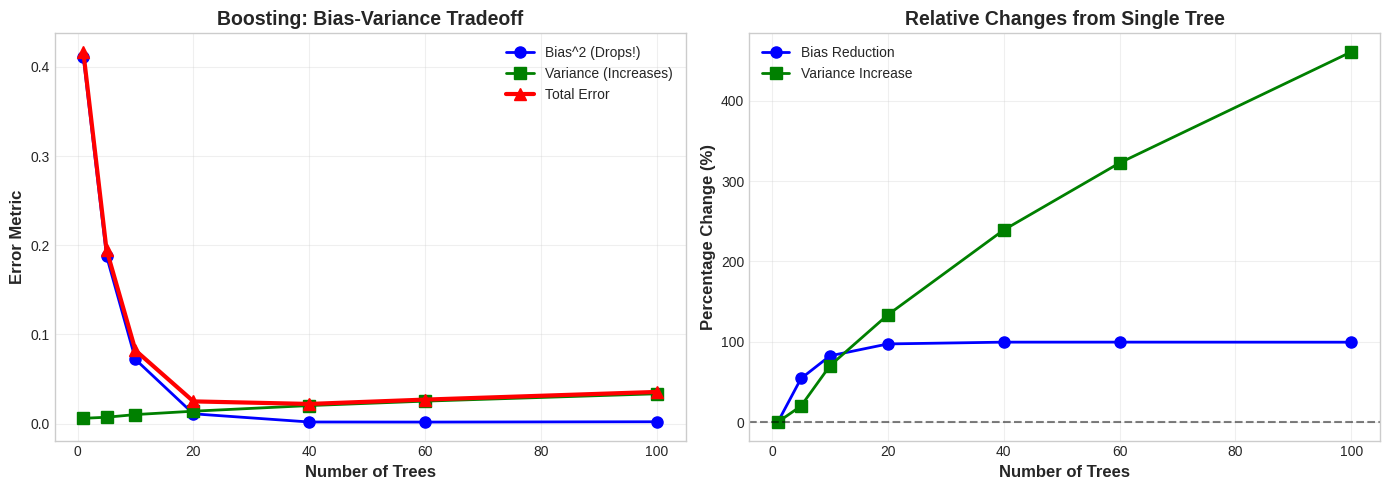


KEY FINDINGS:
Bias reduced by: 99.49%
Variance increased by: 461.13%
Net effect: Total error reduced by 91.48%

CONCLUSION: Boosting reduces BIAS but increases VARIANCE!
This is opposite to Bagging.


In [7]:
# Test data for bias-variance computation
X_plot_bv = np.arange(0.0, 5.0, 0.05)[:, np.newaxis]
y_true_bv = np.sin(X_plot_bv).ravel()

def simulate_boosting_bias_variance(n_tree_list, n_simulations=20):
    """Compute bias-variance for gradient boosting."""
    biases, variances, errors = [], [], []
    
    print(f"Running Boosting Simulation ({n_simulations} iterations)...\n")
    print(f"{'Trees':<8} | {'Bias^2':<10} | {'Variance':<10} | {'Error':<10}")
    print("-" * 50)
    
    for n_trees in n_tree_list:
        all_predictions = []
        
        for i in range(n_simulations):
            np.random.seed(i)
            # Generate random training data
            X_train_sim = np.sort(5 * np.random.rand(80, 1), axis=0)
            y_train_sim = np.sin(X_train_sim).ravel() + 0.3 * np.random.randn(80)
            
            # Train Gradient Boosting (weak learners)
            model = MyGradientBoostingRegressor(
                n_estimators=n_trees,
                learning_rate=0.1,
                max_depth=2
            )
            model.fit(X_train_sim, y_train_sim)
            
            all_predictions.append(model.predict(X_plot_bv))
        
        all_predictions = np.array(all_predictions)
        
        # Compute metrics
        main_prediction = np.mean(all_predictions, axis=0)
        bias_sq = np.mean((main_prediction - y_true_bv) ** 2)
        variance = np.mean(np.var(all_predictions, axis=0))
        total_error = bias_sq + variance
        
        print(f"{n_trees:<8} | {bias_sq:.6f}  | {variance:.6f}  | {total_error:.6f}")
        
        biases.append(bias_sq)
        variances.append(variance)
        errors.append(total_error)
    
    return biases, variances, errors

# Run simulation
n_trees_range = [1, 5, 10, 20, 40, 60, 100]
biases, variances, errors = simulate_boosting_bias_variance(n_trees_range)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: All components
axes[0].plot(n_trees_range, biases, 'o-', color='blue', 
            label='Bias^2 (Drops!)', linewidth=2, markersize=8)
axes[0].plot(n_trees_range, variances, 's-', color='green', 
            label='Variance (Increases)', linewidth=2, markersize=8)
axes[0].plot(n_trees_range, errors, '^-', color='red', 
            label='Total Error', linewidth=3, markersize=8)
axes[0].set_xlabel('Number of Trees', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Error Metric', fontsize=12, fontweight='bold')
axes[0].set_title('Boosting: Bias-Variance Tradeoff', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Relative changes
bias_reduction = [(biases[0] - b) / biases[0] * 100 for b in biases]
variance_increase = [(v - variances[0]) / variances[0] * 100 for v in variances]

axes[1].plot(n_trees_range, bias_reduction, 'o-', color='blue',
            label='Bias Reduction', linewidth=2, markersize=8)
axes[1].plot(n_trees_range, variance_increase, 's-', color='green',
            label='Variance Increase', linewidth=2, markersize=8)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Number of Trees', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage Change (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Relative Changes from Single Tree', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("KEY FINDINGS:")
print("="*50)
print(f"Bias reduced by: {bias_reduction[-1]:.2f}%")
print(f"Variance increased by: {variance_increase[-1]:.2f}%")
print(f"Net effect: Total error reduced by {(errors[0] - errors[-1])/errors[0]*100:.2f}%")
print("\nCONCLUSION: Boosting reduces BIAS but increases VARIANCE!")
print("This is opposite to Bagging.")

## Part 7: Overfitting Risk in Boosting

Boosting can overfit if we use too many iterations. Let's see this effect.

Training boosting models with increasing complexity...


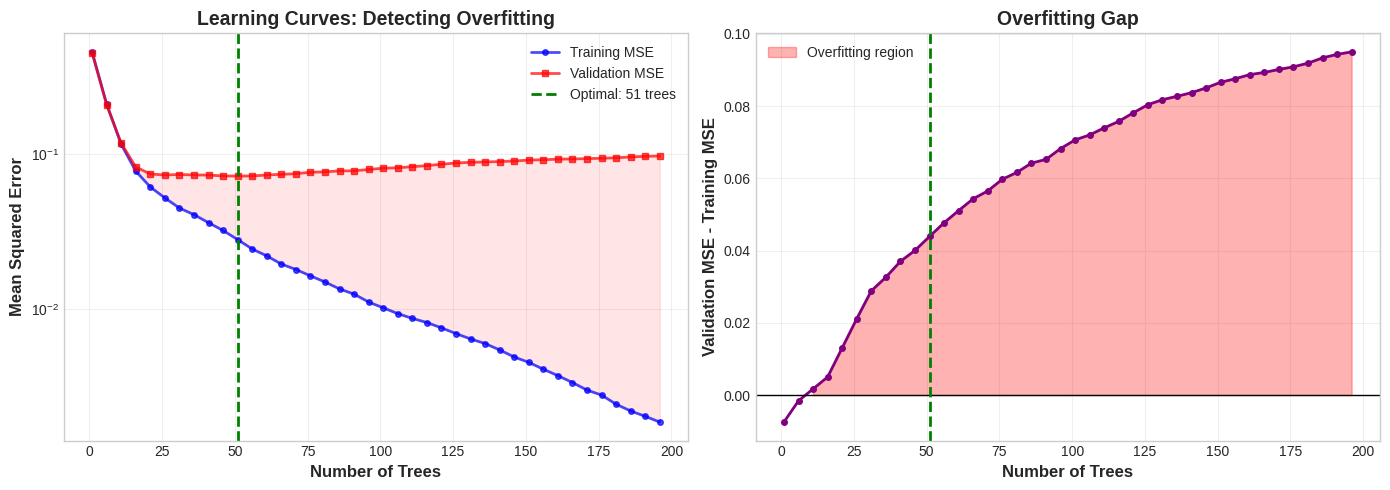


OVERFITTING ANALYSIS:
Optimal number of trees: 51
Min validation MSE: 0.071887

At 200 trees:
  Training MSE: 0.001866
  Validation MSE: 0.096887
  Gap: 0.095021

KEY INSIGHT: Too many trees cause overfitting!
Use early stopping or regularization (learning rate, max_depth).


In [8]:
# Create train/validation split for overfitting analysis
X_train_boost, X_val_boost, y_train_boost, y_val_boost = train_test_split(
    X_gb, y_gb, test_size=0.3, random_state=42
)

# Train with many trees and track performance
n_range = range(1, 201, 5)
train_mses = []
val_mses = []

print("Training boosting models with increasing complexity...")

for n in n_range:
    gbm = MyGradientBoostingRegressor(
        n_estimators=n,
        learning_rate=0.1,
        max_depth=3
    )
    gbm.fit(X_train_boost, y_train_boost)
    
    train_mses.append(mean_squared_error(y_train_boost, gbm.predict(X_train_boost)))
    val_mses.append(mean_squared_error(y_val_boost, gbm.predict(X_val_boost)))

# Find optimal point
optimal_idx = np.argmin(val_mses)
optimal_n = list(n_range)[optimal_idx]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Learning curves
axes[0].plot(n_range, train_mses, 'o-', label='Training MSE', 
            linewidth=2, markersize=4, color='blue', alpha=0.7)
axes[0].plot(n_range, val_mses, 's-', label='Validation MSE', 
            linewidth=2, markersize=4, color='red', alpha=0.7)
axes[0].axvline(x=optimal_n, color='green', linestyle='--', 
               linewidth=2, label=f'Optimal: {optimal_n} trees')
axes[0].fill_between(n_range, train_mses, val_mses, alpha=0.1, color='red')
axes[0].set_xlabel('Number of Trees', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Mean Squared Error', fontsize=12, fontweight='bold')
axes[0].set_title('Learning Curves: Detecting Overfitting', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Plot 2: Train-Validation gap
gap = np.array(val_mses) - np.array(train_mses)
axes[1].plot(n_range, gap, 'o-', linewidth=2, markersize=4, color='purple')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].axvline(x=optimal_n, color='green', linestyle='--', linewidth=2)
axes[1].fill_between(n_range, 0, gap, where=(gap > 0), 
                     alpha=0.3, color='red', label='Overfitting region')
axes[1].set_xlabel('Number of Trees', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Validation MSE - Training MSE', fontsize=12, fontweight='bold')
axes[1].set_title('Overfitting Gap', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nOVERFITTING ANALYSIS:")
print("="*60)
print(f"Optimal number of trees: {optimal_n}")
print(f"Min validation MSE: {min(val_mses):.6f}")
print(f"\nAt 200 trees:")
print(f"  Training MSE: {train_mses[-1]:.6f}")
print(f"  Validation MSE: {val_mses[-1]:.6f}")
print(f"  Gap: {val_mses[-1] - train_mses[-1]:.6f}")
print("\nKEY INSIGHT: Too many trees cause overfitting!")
print("Use early stopping or regularization (learning rate, max_depth).")

## Summary: Key Takeaways

### What We Learned:

1. **The Problem: High Bias**
   - Weak learners (stumps) underfit
   - Single simple model cannot capture complex patterns

2. **The Solution: Sequential Learning**
   - **AdaBoost:** Upweight misclassified samples
   - **Gradient Boosting:** Fit residual errors directly
   - Each new model corrects previous mistakes

3. **Bias-Variance Tradeoff**
   - Reduces BIAS (opposite of Bagging)
   - Increases VARIANCE slightly
   - Net effect: Lower total error

4. **Overfitting Risk**
   - High risk with too many iterations
   - Use early stopping on validation set
   - Regularization: learning rate, max_depth

### When to Use Boosting:

- High-bias models (weak learners)
- Need maximum accuracy (competitions)
- Have clean data (sensitive to outliers)
- Can afford sequential training time

### Comparison with Bagging:

| Aspect | Bagging | Boosting |
|--------|---------|----------|
| Goal | Reduce variance | Reduce bias |
| Training | Parallel | Sequential |
| Base models | Strong (deep trees) | Weak (stumps/shallow) |
| Overfitting | Low risk | High risk |
| Speed | Fast | Slower |
| Outlier sensitivity | Robust | Sensitive |

### Modern Boosting Algorithms:

- **XGBoost:** Optimized gradient boosting with regularization
- **LightGBM:** Fast, efficient for large datasets
- **CatBoost:** Handles categorical features well

All based on the same core principle: learn from mistakes!